# Generic sklearn discriminators

In [1]:
%matplotlib inline

In [2]:
# Add path for pop_kernels package
import sys
sys.path.insert(0, "..")

In [3]:
import pickle
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import qiskit.tools.jupyter
from qiskit.ignis.measurement.discriminator.iq_discriminators import (
    LinearIQDiscriminator,
    QuadraticIQDiscriminator,
)
from qiskit.result import Result

from pop_kernels import SklearnIQDiscriminator
from sklearn.svm import SVC

plt.rcParams['font.size'] = 14

qiskit.__qiskit_version__

{'qiskit-terra': '0.11.0',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.3.0',
 'qiskit-ibmq-provider': '0.4.4',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.14.0'}

In [4]:
q = 0

In [5]:
with open('ibmq_armonk_results.pickle', 'rb') as handle:
    res = pickle.load(handle)
result = Result.from_dict(res)

In [6]:
discriminators = [
    SklearnIQDiscriminator(SVC(C=C, kernel="rbf"), result, [q], ['0', '1'])
    for C in [1.0, 1.5, 3.0, 5.0, 10.0, 20.0, 30.0, 40.0]
]

In [7]:
def misclassifications(dscr):
    """ Return the list of misclassified IQ values. """
    x_data = np.array(dscr._xdata)
    y_data = np.array(dscr._ydata)
    y_disc = np.array(dscr.discriminate(dscr._xdata))
    misclassified = x_data[y_disc != y_data]
    return misclassified

In [8]:
df_errors = pd.DataFrame([
    {"classifier": str(d._classifier), "C": d._classifier.C, "errors": len(misclassifications(d))}
    for d in discriminators
])
df_errors.sort_values("C", inplace=True)
df_errors

,classifier,C,errors
0,"SVC(C=1.0, break_ties=False, cache_size=200, c...",1.0,43
1,"SVC(C=1.5, break_ties=False, cache_size=200, c...",1.5,42
2,"SVC(C=3.0, break_ties=False, cache_size=200, c...",3.0,42
3,"SVC(C=5.0, break_ties=False, cache_size=200, c...",5.0,42
4,"SVC(C=10.0, break_ties=False, cache_size=200, ...",10.0,41
5,"SVC(C=20.0, break_ties=False, cache_size=200, ...",20.0,41
6,"SVC(C=30.0, break_ties=False, cache_size=200, ...",30.0,41
7,"SVC(C=40.0, break_ties=False, cache_size=200, ...",40.0,41


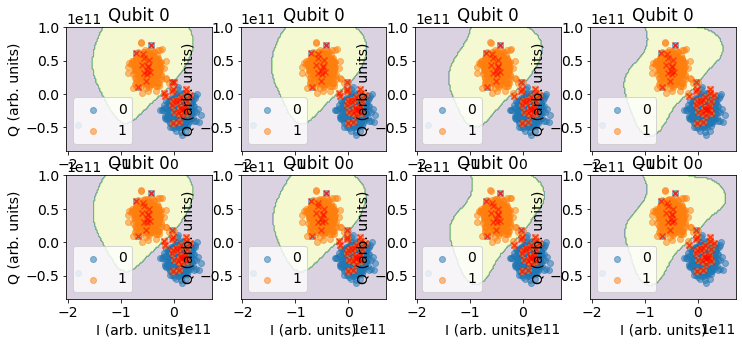

In [9]:
fig, ax = plt.subplots(2, len(discriminators) // 2, figsize=(12,5))

for i, dscr in enumerate(discriminators):
    dscr.plot(ax[i % 2, i // 2], flag_misclassified=True, show_boundary=True)

In [10]:
def zeros_and_ones(dscr, x):
    """ Return the number of zeros and ones detected in the result. """
    y = dscr.discriminate(x)
    return len(y[y == "0"]), len(y[y == "1"])

In [11]:
# calculate the numbers of zeros and ones detected in the X90 test data
x = np.array(result.results[2].data.memory)[:, 0, :]
zos = [zeros_and_ones(d, x) for d in discriminators]

df_x90 = pd.DataFrame([
    {
        "classifier": str(d._classifier),
        "C": d._classifier.C,
        "0": zo[0],
        "1": zo[1],
        "Fraction of 1s": (zo[1] / sum(zo)),
    } for d, zo in zip(discriminators, zos)
])
df_x90.sort_values("C", inplace=True)
df_x90

,classifier,C,0,1,Fraction of 1s
0,"SVC(C=1.0, break_ties=False, cache_size=200, c...",1.0,242,270,0.527344
1,"SVC(C=1.5, break_ties=False, cache_size=200, c...",1.5,242,270,0.527344
2,"SVC(C=3.0, break_ties=False, cache_size=200, c...",3.0,242,270,0.527344
3,"SVC(C=5.0, break_ties=False, cache_size=200, c...",5.0,242,270,0.527344
4,"SVC(C=10.0, break_ties=False, cache_size=200, ...",10.0,242,270,0.527344
5,"SVC(C=20.0, break_ties=False, cache_size=200, ...",20.0,242,270,0.527344
6,"SVC(C=30.0, break_ties=False, cache_size=200, ...",30.0,242,270,0.527344
7,"SVC(C=40.0, break_ties=False, cache_size=200, ...",40.0,242,270,0.527344
